## Convirtiendo un pdf en markdown

If you want begin with a more simple example [pdf2images.ipynb]("./pdf2images.ipynb")

## pdf to markdowns

* Define your Documents and Transformers

In [ ]:
# Install pdf2image for this example
# !pip install pdf2image

In [2]:
from document_transformer import Document, DocumentTransformer
from typing import List
from pathlib import Path
import pdf2image

class PDFDocument(Document):
    """Custom class to PDF Documents"""

class ImageDocument(Document):
    """Custom class to Image Documents"""
    def saver(self, path):
        self.data.save(path)
        return self

class MarkdownDocument(Document):
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

class PDF2Images(DocumentTransformer):
    input: PDFDocument = None
    output: List[ImageDocument] = []

    def transformer(self) -> List[ImageDocument]:
        """Divide en páginas el documento pdf"""
        images = pdf2image.convert_from_path(self.input.path)
        return [
            ImageDocument(
                metadata={'pdf_path': Path(self.input.path).name, 'page': i+1, 'size': image.size},
                data=image,
            )
            for i, image in enumerate(images)
        ]

* Define the `Image2Markdown` transformer, which takes an `ImageDocument` and transforms it into a `MarkdownDocument`.
* To keep things simple, we'll define an OCR method with dummy data. However, it's important that you implement your own OCR logic here.

In [3]:
class Image2Markdown(DocumentTransformer):
    input: ImageDocument = None
    output: MarkdownDocument = None

    def ocr(self):
        """ocr, puede ser una función externa"""
        return f"OCR {self.input.metadata['page']}"

    def transformer(self):
        ocr_text = self.ocr()
        return MarkdownDocument(
            metadata={'image_path': self.input.path, 'page': self.input.metadata['page']},
            data=ocr_text
        )

run it!

In [5]:
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

for image in images:
    image.save(path=f'images/pag_{image.metadata["page"]}.jpg')
    markdown = Image2Markdown(input=image).run()
    markdown.save(path=f'images/pag_{image.metadata["page"]}.md')
    print(markdown)

id='709c2ecf-d097-40ae-b4f4-62e84d4d1c7b' path='images/pag_1.md' data='OCR 1' metadata={'image_path': 'images/pag_1.jpg', 'page': 1} parents=['c31eda7e-aba8-451c-9f71-77a52151b72e'] childrens=[]
id='27ea53fb-d7f8-414d-badc-b1f5e495e296' path='images/pag_2.md' data='OCR 2' metadata={'image_path': 'images/pag_2.jpg', 'page': 2} parents=['5f371840-e532-41d3-ac40-341695d3c91d'] childrens=[]
id='7169c182-22bc-4c3e-8a5d-fad3aed3251b' path='images/pag_3.md' data='OCR 3' metadata={'image_path': 'images/pag_3.jpg', 'page': 3} parents=['b83cd5e1-9937-4366-bfbd-14e98d5b4de1'] childrens=[]


Now the diversion! Use your document transformer

In [4]:
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

for image in images:
    image.save(path=f'images/pag_{image.metadata["page"]}.jpg')
    print(f"Imagen: {image.id}")
    print(f"Parents: {image.parents}")
    print(f"Metadata: {image.metadata}")

Imagen: 3a72b721-569e-47f0-b12b-d25439cdf52b
Parents: ['fbf8f600-a8fb-47a9-b755-ed63a9506387']
Metadata: {'pdf_path': 'document.pdf', 'page': 1, 'size': (1700, 2200)}
Imagen: 807caf6f-8d54-4e0a-bd80-71410d3749ad
Parents: ['fbf8f600-a8fb-47a9-b755-ed63a9506387']
Metadata: {'pdf_path': 'document.pdf', 'page': 2, 'size': (1700, 2200)}
Imagen: ed91dbda-93de-4dea-809a-350390b3b4ca
Parents: ['fbf8f600-a8fb-47a9-b755-ed63a9506387']
Metadata: {'pdf_path': 'document.pdf', 'page': 3, 'size': (1700, 2200)}


* If you prefier, you can define a `Pipeline`.
* In a list insert each transformer  and plot it!

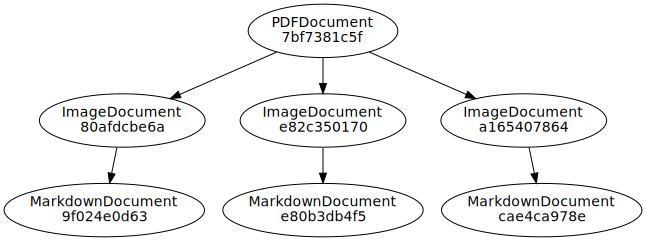

In [10]:
from document_transformer import Pipeline
from document_transformer.utils import plot_graph

pdf_doc = PDFDocument(path="document.pdf")
pipeline = Pipeline(transformers=[PDF2Images(), Image2Markdown()])
markdowns = pipeline.run(input=pdf_doc)
plot_graph(pipeline.get_traces())

All is ok?
Save only markdowns!

In [14]:
for markdown in markdowns:
    markdown.save(path=f'images/pag_{markdown.metadata["page"]}.md')

But if you prefer, you can instruct from Pipeline directly!

In [18]:
pdf_doc = PDFDocument(path="document.pdf")
pipeline = Pipeline(transformers=[
    PDF2Images(),
    Image2Markdown(to='images/pag_{metadata[page]}.md')
])

pipeline.run(input=pdf_doc)

[MarkdownDocument(id='2ada1fb8-6dad-427a-af36-c777bc05ac88', path='images/pag_1.md', data='OCR 1', metadata={'image_path': None, 'page': 1}, parents=['fa670f2d-0b27-47fe-9840-820217006f08'], childrens=[]),
 MarkdownDocument(id='27b3df4c-4503-4fe8-bf9d-7486b3e48951', path='images/pag_2.md', data='OCR 2', metadata={'image_path': None, 'page': 2}, parents=['8700860a-9bb1-40c0-b0ee-a473a9dd7ed4'], childrens=[]),
 MarkdownDocument(id='387ef81a-fccb-47e3-89a8-e7d70afab97a', path='images/pag_3.md', data='OCR 3', metadata={'image_path': None, 'page': 3}, parents=['b7fffb37-593e-49b4-9bd6-a9cc246a8aba'], childrens=[])]

## Combine markdowns

Now, we are going to merge the markdowns. For that we need to increase the skills of `MarkdownDocument`. Let me define the `appender` method.

In [19]:
class MarkdownDocument(Document):
    data: str = ''
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

    def appender(self, other):
        """Append other markdown document content to this one"""
        self.data += other.data + '\n'
        return self


That is all, now we can to append each markdown document to another

In [20]:
# create images
pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

# Initialize the markdown document
markdown_doc = MarkdownDocument()
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdown_doc.append(markdown)

markdown_doc.save(path="document.md")

MarkdownDocument(id='254b4601-e736-49f6-8e1d-a14ea3ad101a', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents=['4e36ce13-f5b5-451b-9505-936ce4c150ee', '22af6059-a00f-4ac1-af7e-d767986b29eb', '37f51ac4-4100-4efc-afd2-741ebc399891'], childrens=[])

The library supports initializing an empty list and combining markdown documents at the end


In [22]:

pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

# initialize an empty list of markdowns
markdowns = []
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdowns.append(markdown)

# Combine them into a single markdown document and save it
markdown_doc = MarkdownDocument().extend(markdowns)
markdown_doc.save(path="document.md")

MarkdownDocument(id='5ffe31ac-e280-4e9e-afd1-9ab0b51340d9', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents=['d41e0463-4063-4f29-b002-a2c25185669e', 'b22a6640-35a2-4388-80e1-4366d8fbc609', '5841caae-c3b9-4fdc-bbed-3aef398b075c'], childrens=[])

Alternatively, you can always create a `DocumentTransformer` class to handle this task


In [30]:
class CombineMarkdowns(DocumentTransformer):
    input: List[MarkdownDocument] = []
    output: MarkdownDocument = None

    def transformer(self):
        return MarkdownDocument().extend(self.input)

pdf_doc = PDFDocument(path="document.pdf")
images = PDF2Images(input=pdf_doc).run()

markdowns = []
for image in images:
    path = f'images/pag_{image.metadata["page"]}'
    image.save(path=path + '.jpg')
    markdown = Image2Markdown(input=image).run().save(path=path + '.md')
    markdowns.append(markdown)

markdown_doc = CombineMarkdowns(input=markdowns).run()
markdown_doc.save(path="document.md")

MarkdownDocument(id='391c97a7-867f-44d2-8f51-b76ac53b186c', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents=['b391ea37-1999-438d-985f-45225faf827c', '5cb1c4c2-c3af-435c-b62a-601d370c5ff0', '576db8e4-9f4a-409b-acef-34c188bd8b30'], childrens=[])

Which brings a reward! Now you can extend your Pipeline

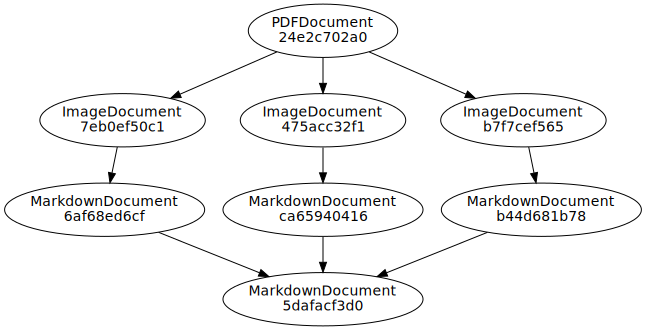

In [26]:
# Define Pipeline
pipeline = Pipeline(transformers=[
    PDF2Images(), Image2Markdown(), CombineMarkdowns()
])

# Run and visualize it!
pdf_doc = PDFDocument(path="document.pdf")
markdown_doc = pipeline.run(input=pdf_doc)
plot_graph(pipeline.get_traces())

Remember, if you need to save each part, you can specify it in the Pipeline


In [31]:
# Define Pipeline
pipeline = Pipeline(transformers=[
    PDF2Images(to='images/pag_{metadata[page]}.jpg'),
    Image2Markdown(to='images/pag_{metadata[page]}.md'),
    CombineMarkdowns(to='document.md')
])

# Run it!
pdf_doc = PDFDocument(path="document.pdf")
pipeline.run(input=pdf_doc)

MarkdownDocument(id='79b0149f-adeb-49f8-b18d-1c6659428960', path='document.md', data='OCR 1\nOCR 2\nOCR 3\n', metadata={}, parents=['6d8816a9-8242-4768-a7dc-7b861e75fc93', '373d49a9-7f21-4d02-95c2-9e394a8640c8', '0d440ff8-9a1f-4c9b-b4b9-b8fdc4a3e986'], childrens=[])

## All togheter!

Next all definitions and final Pipeline. Insert more than one input document if you need it!

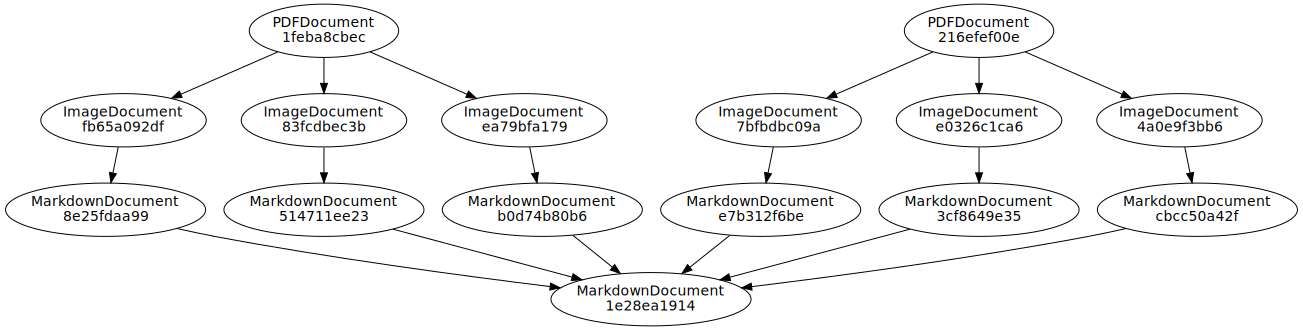

In [36]:
from document_transformer import Document, DocumentTransformer
from document_transformer.utils import plot_graph
from typing import List
from pathlib import Path
import pdf2image

######################################################
# Documents
######################################################
class PDFDocument(Document):
    """Custom class to PDF Documents"""

class ImageDocument(Document):
    """Custom class to Image Documents"""
    def saver(self, path):
        self.data.save(path)
        return self

class MarkdownDocument(Document):
    data: str = ''
    def saver(self, path):
        with open(path, 'w') as file:
            file.write(self.data)
        return self

    def appender(self, other):
        """Append other markdown document content to this one"""
        self.data += other.data + '\n'
        return self

######################################################
# Transfomers
######################################################
class PDF2Images(DocumentTransformer):
    input: PDFDocument = None
    output: List[ImageDocument] = []

    def transformer(self) -> List[ImageDocument]:
        """Divide en páginas el documento pdf"""
        images = pdf2image.convert_from_path(self.input.path)
        return [
            ImageDocument(
                metadata={'pdf_path': Path(self.input.path).name, 'page': i+1, 'size': image.size},
                data=image,
            )
            for i, image in enumerate(images)
        ]

class Image2Markdown(DocumentTransformer):
    input: ImageDocument = None
    output: MarkdownDocument = None

    def ocr(self):
        """ocr, puede ser una función externa"""
        return f"OCR {self.input.metadata['page']}"

    def transformer(self):
        ocr_text = self.ocr()
        return MarkdownDocument(
            metadata={'image_path': self.input.path, 'page': self.input.metadata['page']},
            data=ocr_text
        )

class CombineMarkdowns(DocumentTransformer):
    input: List[MarkdownDocument] = []
    output: MarkdownDocument = None

    def transformer(self):
        return MarkdownDocument().extend(self.input)
    

######################################################
# Pipeline
######################################################
pipeline = Pipeline(transformers=[
    PDF2Images(to='images/pag_{metadata[page]}.jpg'),
    Image2Markdown(to='images/pag_{metadata[page]}.md'),
    CombineMarkdowns(to='document.md')
])

# Run it!
pdf_doc1 = PDFDocument(path="document.pdf")
pdf_doc2 = PDFDocument(path="document.pdf")

markdown_doc = pipeline.run(input=[pdf_doc1, pdf_doc2])
plot_graph(pipeline.get_traces())

## Conclusions

As you can see, `document-transformer` is your friend when it comes to organizing your transformer pipeline. Simply define your components, and `document-transformer` will handle the rest, ensuring traceability and organization. Reuse your work in any project!